In [7]:
from transformers import DateTimeTransformer, AirportLatLongTransformer
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from scipy.stats import gaussian_kde

## Visualizations

As a proof of concept for this analysis, some common sense analyses can be visualized to show that components such as airport, airline, month, and departure time play a role in the frequency of flight delays. The descriptive data analysis methods used will not only provide useful insights into the airline operations data, but will also aid in identifying which metrics should be included as independent variables in a predictive analysis. 

### Delays by Airline Code

Some common causes for delays include aircraft maintenance and crew availability. These issues are often exacerbated at certain airlines, likely due to management practices, low salaries, and staffing issues for pilots, flight attendants, and maintenance personnel.

This correlation can be visualized through plotting each different airline carrier to their ratio of delays to on-time flights.

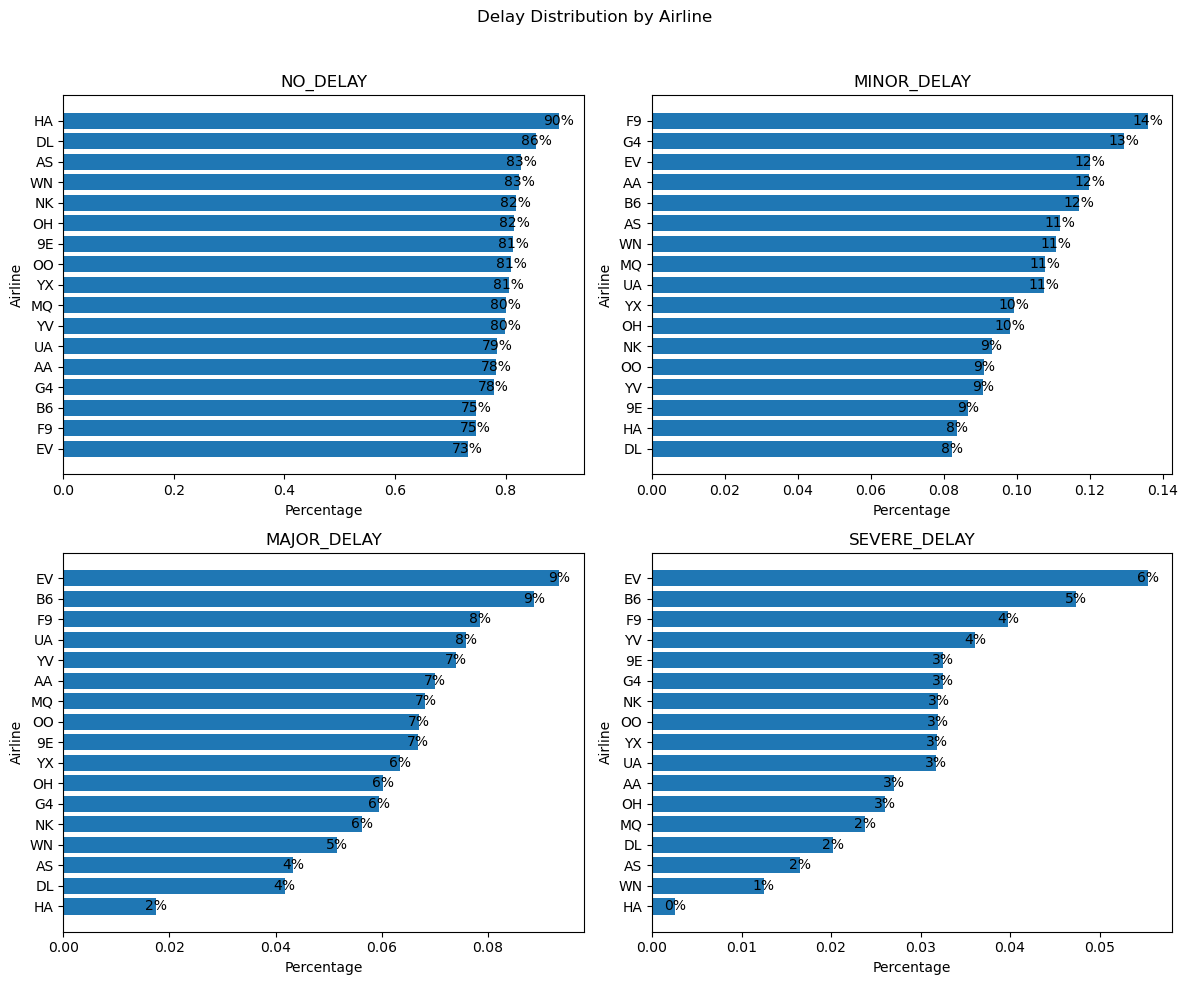

In [8]:
df = pd.read_csv('data/2019_prepared.csv')
df = DateTimeTransformer().transform(df)
df = AirportLatLongTransformer().transform(df)

total_flights = df.groupby('OP_UNIQUE_CARRIER').size()
delay_counts = df.groupby(['OP_UNIQUE_CARRIER', 'DELAY_CATEGORY']).size().unstack(fill_value=0)
delay_percentages = delay_counts.div(total_flights, axis=0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Delay Distribution by Airline')

delay_categories = ['NO_DELAY', 'MINOR_DELAY', 'MAJOR_DELAY', 'SEVERE_DELAY']
for ax, delay_category in zip(axes.flatten(), delay_categories):
    sorted_data = delay_percentages[delay_category].sort_values()
    ax.barh(sorted_data.index, sorted_data)
    ax.set_title(f'{delay_category}')
    ax.set_ylabel('Airline')
    ax.set_xlabel('Percentage')
    for i, txt in enumerate(sorted_data):
        ax.annotate(f'{txt*100:.0f}%', (sorted_data.iloc[i], sorted_data.index[i]), ha='center', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


From reading these plots, it's apparent that airlines such as DL (Delta), HA (Hawaiian), and WN (Southwest) show a higher percentage of on-time flights, whereas budget airlines such as F9 (Frontier), G4 (Allegiant), and B6 (JetBlue) tend to have a higher percentage of delayed flights.

Based on this analysis, it's reasonable to presume that the operating airline plays a role in the possibility of a flight becoming delayed, and should therefore be incorporated as an independent variable in an airline delay prediction model.

### Delays by Departure Hour

Most airlines will schedule their flights to occur during daytime hours. While there are flights (typically referred to as 'red-eye' flights) that occur outside this timeframe, most passengers expect to travel during the waking hours. Early and late-morning delays can cause a chain reaction, resulting in most delays accumulating in the afternoon or evening, with the root cause being late inbound aircraft.

This correlation can be visualized by plotting delay frequency across the hours of the day.

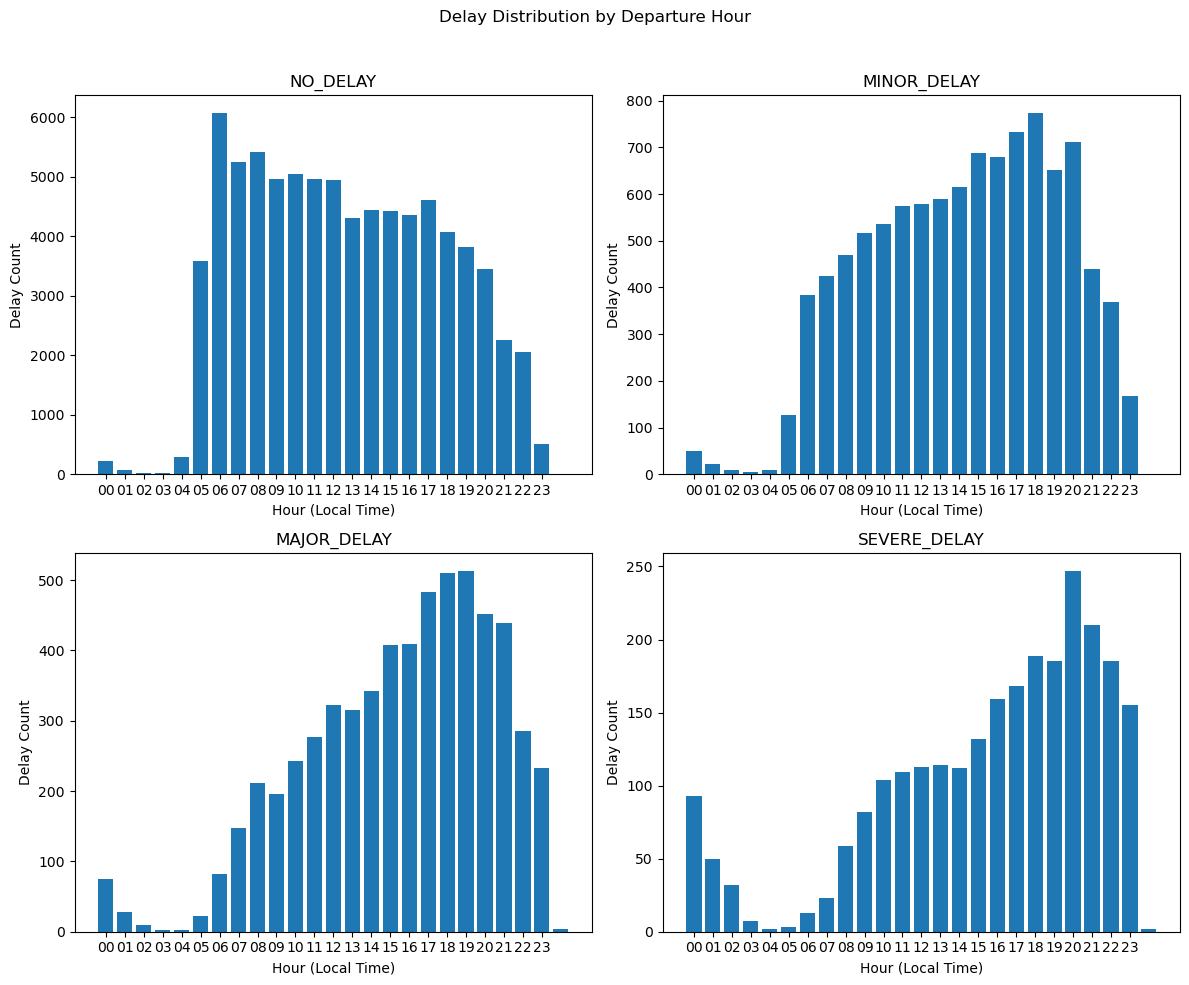

In [9]:
df['DEP_HOUR'] = df['DEP_MINUTES'].apply(lambda x: x // 60)
delay_counts = df.groupby(['DEP_HOUR', 'DELAY_CATEGORY']).size().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Delay Distribution by Departure Hour')

delay_categories = ['NO_DELAY', 'MINOR_DELAY', 'MAJOR_DELAY', 'SEVERE_DELAY']
for ax, delay_category in zip(axes.flatten(), delay_categories):
    ax.bar(delay_counts.index, delay_counts[delay_category])
    ax.set_title(f'{delay_category}')
    ax.set_xlabel('Hour (Local Time)')
    ax.set_ylabel('Delay Count')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{i:02}' for i in range(24)])    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The chart representing 'NO_DELAY' clearly shows that most on-time flights depart in the morning, between 6am and 12pm. The remaining charts, each representing the various delay severity categories, clearly shows that late afternoon and evening flights, from about 3pm until 8pm, demonstrate the highest number of total delays.

Based on this trend, it is important that the departure time be included in a predictive model for flight delays.

### Delays by Departure or Arrival City

The airport from which a flight departs might result in a higher chance of a delay if that airport is known for having weather at certain times of the day. The arrival airport might also experience regular weather and ATC delays at certain times as well. ATL (Atlanta) airport is a good example, residing in the southern US where afternoon thunderstorms are frequent and common - and handling the highest amount of air traffic in the world. ATC will often have to route flights around thunderstorms, causing air traffic congestion and ATC "ground stops" - where departing flights are held at the departure airport until air traffic congestion is reduced.

These trends can be expressed by charting the percentage of delayed flights for the airports with the top 15 most delays.

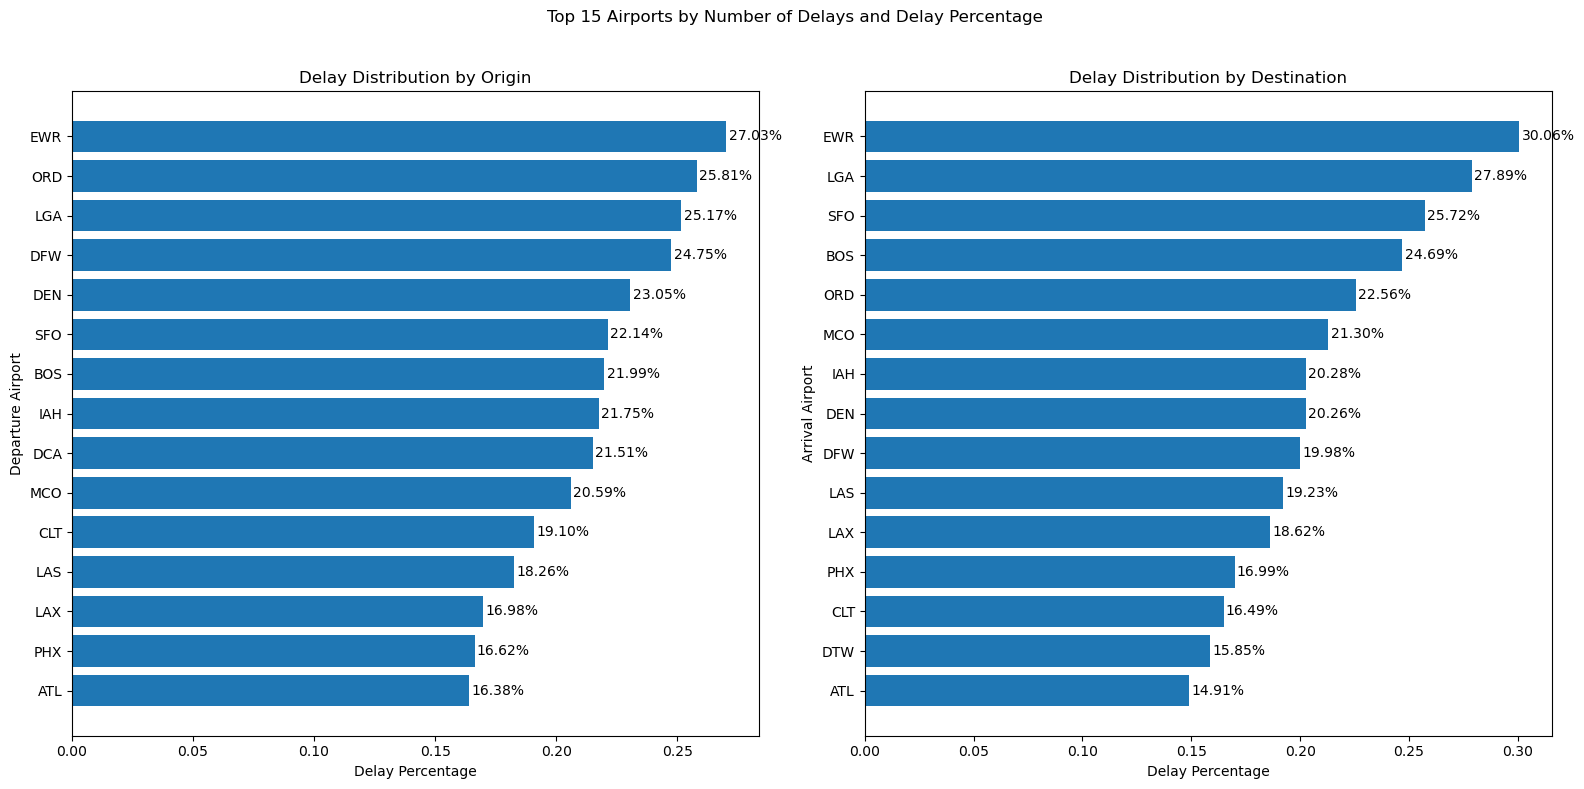

In [10]:
origin_total_flights = df.groupby('ORIGIN').size()
origin_delay_counts = df[df['DELAY_CATEGORY'] != 'NO_DELAY'].groupby('ORIGIN').size()
sorted_origin_delays = origin_delay_counts.sort_values(ascending=False).nlargest(15)
sorted_origin_percentages = sorted_origin_delays.div(origin_total_flights[sorted_origin_delays.index]).sort_values()

dest_total_flights = df.groupby('DEST').size()
dest_delay_counts = df[df['DELAY_CATEGORY'] != 'NO_DELAY'].groupby('DEST').size()
sorted_dest_delays = dest_delay_counts.sort_values(ascending=False).nlargest(15)
sorted_dest_percentages = sorted_dest_delays.div(dest_total_flights[sorted_dest_delays.index]).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Top 15 Airports by Number of Delays and Delay Percentage')

axes[0].barh(sorted_origin_percentages.index, sorted_origin_percentages)
axes[0].set_title('Delay Distribution by Origin')
axes[0].set_xlabel('Delay Percentage')
axes[0].set_ylabel('Departure Airport')
for i, txt in enumerate(sorted_origin_percentages):
    axes[0].annotate(f'{txt*100:.2f}%', (txt + 0.001, i), va='center')

axes[1].barh(sorted_dest_percentages.index, sorted_dest_percentages)
axes[1].set_title('Delay Distribution by Destination')
axes[1].set_xlabel('Delay Percentage')
axes[1].set_ylabel('Arrival Airport')
for i, txt in enumerate(sorted_dest_percentages):
    axes[1].annotate(f'{txt*100:.2f}%', (txt + 0.001, i), va='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From these visualizations (and depending on the overall sample), airports like ORD (Chicago) and DEN (Denver) tend to have up to 25% of their outbound flights delayed, and airports such as EWR (Newark) and LGA (LaGuardia) often have nearly 30% of their inbound flights delayed.

This relationship can be further visualized over a map of the United States, highlighting regions that experience more delays for arriving or departing flights.

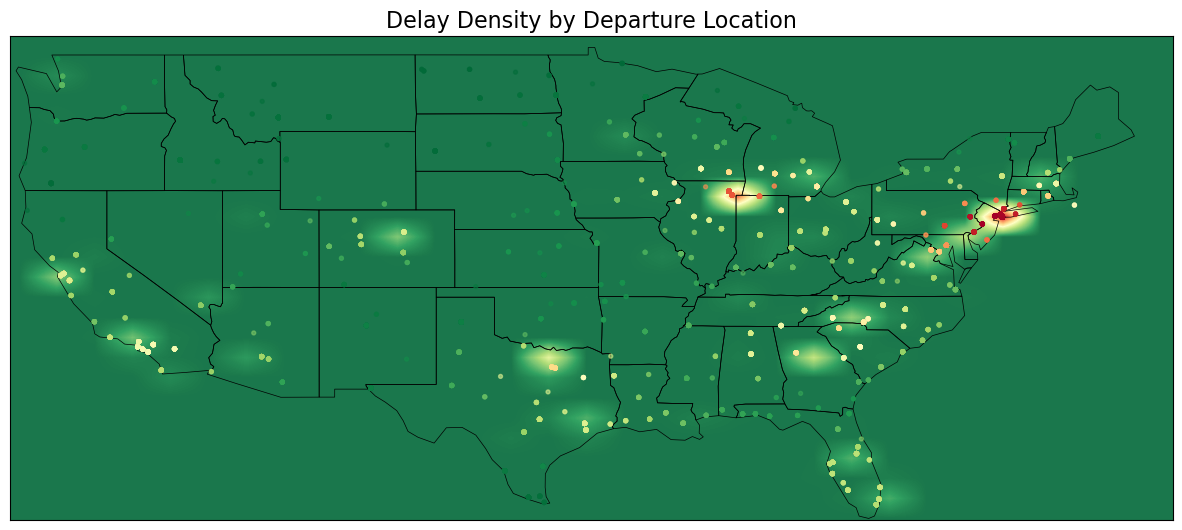

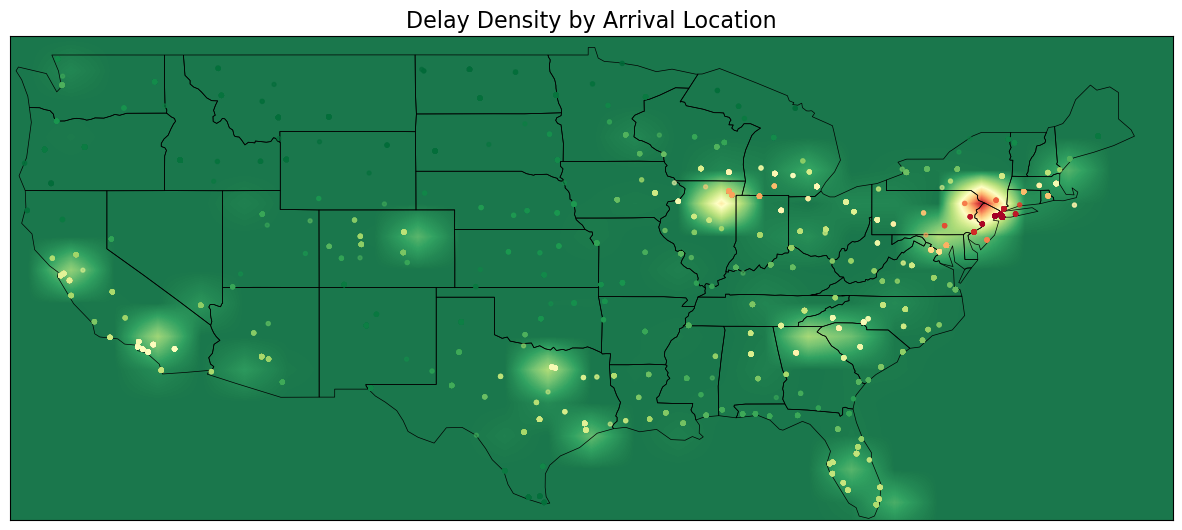

In [11]:
def plot_lat_lon_delays(title: str, longitude: str, latitude: str):
    map = gpd.read_file('data/ne_110m_admin_1_states_provinces.shp')

    delayed_flights = df[df["DELAY_CATEGORY"] != "NO_DELAY"]

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_xlim(-125, -65)
    ax.set_ylim(25, 50)
    ax.set_xticks([])
    ax.set_yticks([])

    xy = np.vstack([delayed_flights[longitude], delayed_flights[latitude]])
    z = gaussian_kde(xy)(xy)
    heatmap, xedges, yedges = np.histogram2d(delayed_flights[longitude], delayed_flights[latitude], bins=[50, 50], weights=z)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='RdYlGn_r', alpha=0.9, interpolation='bilinear', aspect='auto')

    map.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

    scatter = ax.scatter(delayed_flights[longitude], delayed_flights[latitude], 
                         c=z, s=8, alpha=0.6, cmap='RdYlGn_r')

    plt.title(title, fontsize=16)

    plt.show()

plot_lat_lon_delays('Delay Density by Departure Location', 'ORIGIN_LON', 'ORIGIN_LAT')
plot_lat_lon_delays('Delay Density by Arrival Location', 'DEST_LON', 'DEST_LAT')


A quick review of these maps shows a couple areas that tend to result in the most delays - primarily the New York City metro area and the Chicago metro area. Chicago airports seem to have a higher number of delays for departing flights, while New York City airports seem to have more delays for inbound flights. Extending these effects from the largest airports in these regions (i.e. ORD in Chicago) to other satellite airports in the metro area, such as MDW (Chicago-Midway) or SBN (South Bend, IN) captures the effect of airspace congestion over these densely populated regions.

Both the origin and destination airports and their latitude/longitude coordinates play a factor in the chance of a flight being delayed, and therefore should be included in predictive model training data.